In [1]:
from pycbc.waveform import get_td_waveform
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


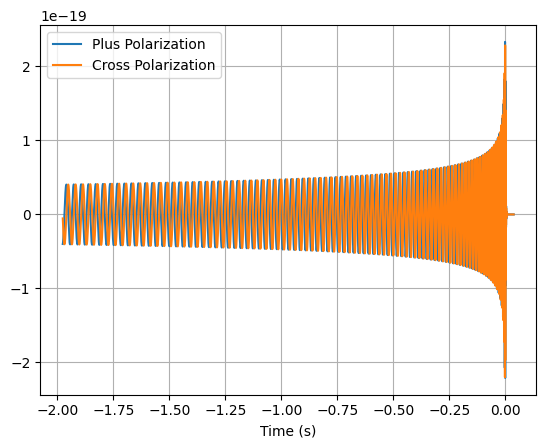

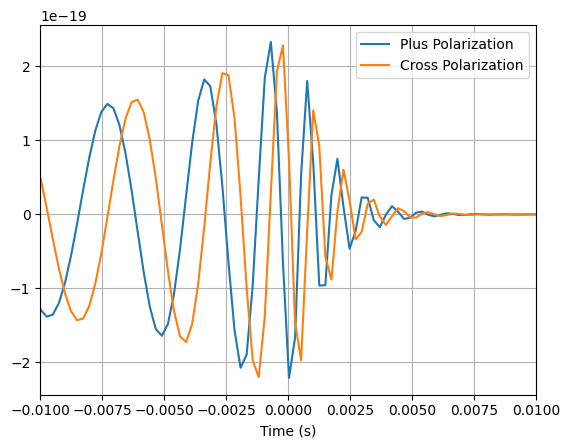

In [2]:
# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
hp, hc = get_td_waveform(
    approximant="SEOBNRv4_opt", mass1=10, mass2=10, delta_t=1.0 / 4096, f_lower=30
)

pylab.plot(hp.sample_times, hp, label="Plus Polarization")
pylab.plot(hp.sample_times, hc, label="Cross Polarization")
pylab.xlabel("Time (s)")
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time#
pylab.plot(hp.sample_times, hp, label="Plus Polarization")
pylab.plot(hp.sample_times, hc, label="Cross Polarization")
pylab.xlabel("Time (s)")
pylab.xlim(-0.01, 0.01)
pylab.legend()
pylab.grid()
pylab.show()

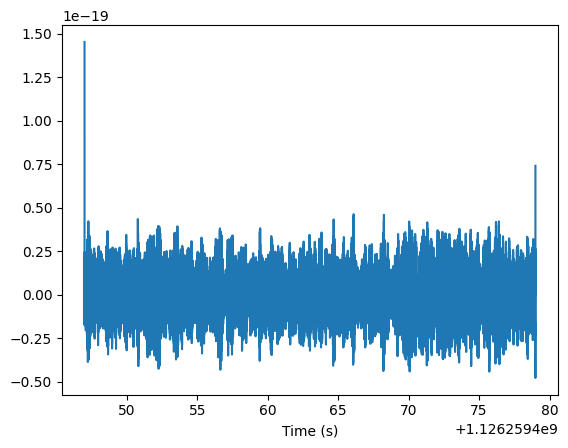

In [3]:
merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain("H1")

# Remove the low frequency content and downsample the data to 2048Hz
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0 / 2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel("Time (s)")
pylab.show()

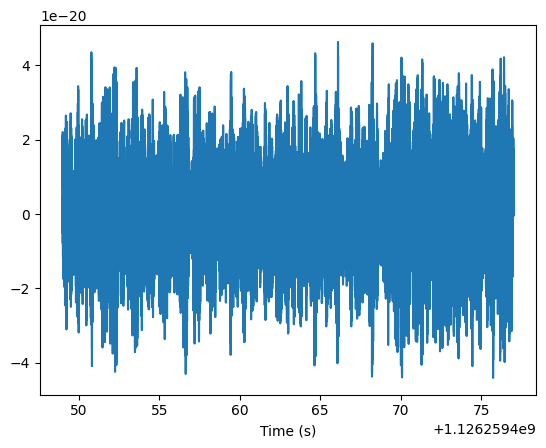

In [4]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel("Time (s)")
pylab.show()

(30, 1024)

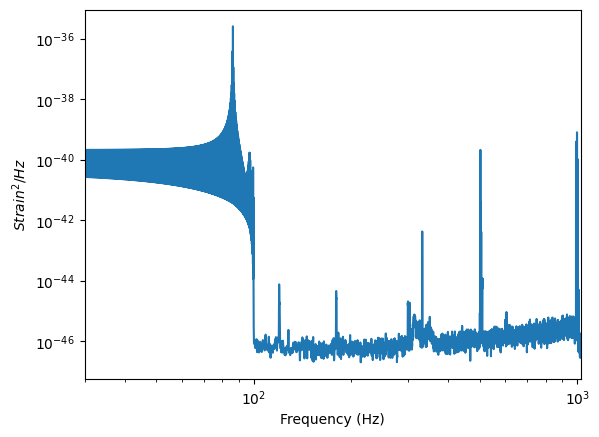

In [7]:
# Estimate the power spectral density

# We use 4 second samles of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to informat the function to not include frequencies
# below this frequency.
psd = inverse_spectrum_truncation(
    psd, int(4 * conditioned.sample_rate), low_frequency_cutoff=100
)

pylab.loglog(psd.sample_frequencies, psd)
pylab.ylabel("$Strain^2 / Hz$")
pylab.xlabel("Frequency (Hz)")
pylab.xlim(30, 1024)

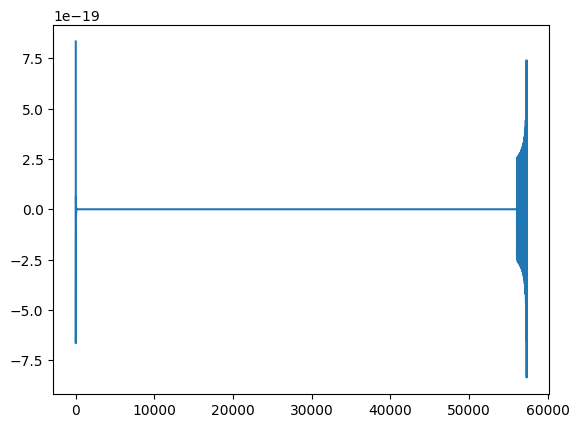

In [6]:
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume equal masses, which is within the posterior probability
# of GW150914.
m = 36  # Solar masses
hp, hc = get_td_waveform(
    approximant="SEOBNRv4_opt",
    mass1=m,
    mass2=m,
    delta_t=conditioned.delta_t,
    f_lower=20,
)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the
# first bin of the data.

# This function rotates the vector by a fixed amount of time.
# It treats the data as if it were on a ring. Note that
# time stamps are *not* in general affected, but the true
# position in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to
# shift the merger into position
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(template)
pylab.show()